In [1]:
DATA_DIR = "benchmark-hdd"

In [2]:
%matplotlib inline

In [3]:
XFER_TYPE_MAPPING = {
        0: "Storage->GPU (GDS)",
        1: "Storage->CPU",
        2: "Storage->CPU->GPU",
#         3: "Storage->CPU->GPU_ASYNC",
#         4: "Storage->PAGE_CACHE->CPU->GPU",
#         5: "Storage->GPU_ASYNC",
#         6: "Storage->GPU_BATCH" # Experiments failed
    }

In [4]:
OPERATION_TYPE_MAPPING = {
        0: "read",
        1: "write",
        2: "randread",
        3: "randwrite"
    }

In [5]:
xfer_types_to_skip = set(range(7)).difference(XFER_TYPE_MAPPING)
print(xfer_types_to_skip)

{3, 4, 5, 6}


# Throughput and latency

In [6]:
def parse_xfer_type(type_):
    return XFER_TYPE_MAPPING[int(type_)]

In [7]:
def parse_operation_type(type_):
    return OPERATION_TYPE_MAPPING[int(type_)]

In [8]:
from pathlib import Path
import re

import pandas as pd
from pandas.api.types import CategoricalDtype


params_pattern = r"/usr/local/cuda/gds/tools/gdsio[^\n]*-w ([^\s]+) -s ([^\s]+) [^\n]*-x ([^\s]+) -I ([^\s]+) "
results_pattern = r"Throughput: ([^\s]+) GiB/sec, Avg_Latency: ([^\s]+) usecs"
# https://stackoverflow.com/questions/38400595/regex-stop-after-first-match
pattern = rf"{params_pattern}[\S\s]*?{results_pattern}"

path = next(Path(DATA_DIR).glob('slurm-benchmark-*.out'))
measurements = []

with open(path, "r") as f:
    content = f.read()

In [9]:
for match in re.findall(pattern, content):

    if (threads := int(match[0])) == 128:
        continue
    if int(match[2]) in xfer_types_to_skip:
        continue
    measurements.append({
        "threads": threads,
        "file_size":  match[1],
        "xfer_type": parse_xfer_type(match[2]),
        "op_type": parse_operation_type(match[3]),
        "throughput (GiB/sec)": float(match[4]),
        "latency (usecs)": float(match[5])
    })

measurements_df = pd.DataFrame(measurements)

In [10]:
measurements_df["xfer_type"] = measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
measurements_df["op_type"] = measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
measurements_df["file_size"] = measurements_df["file_size"].astype(
    CategoricalDtype(categories=["120M", "500M", "2G", "8G", "32G"], ordered=True)
)

In [11]:
import seaborn as sns

In [12]:
measurements_df

,threads,file_size,xfer_type,op_type,throughput (GiB/sec),latency (usecs)
0,16,2G,Storage->CPU,write,2.831660,5876.711788
1,16,2G,Storage->CPU,read,11.744581,1334.006138
2,16,2G,Storage->CPU,randread,11.130404,1404.735351
3,16,2G,Storage->CPU,randwrite,1.548468,10464.554887
4,16,2G,Storage->GPU (GDS),write,2.464682,6600.615633
...,...,...,...,...,...,...
295,64,32G,Storage->GPU (GDS),randwrite,1.024583,61067.845067
296,64,32G,Storage->CPU->GPU,write,2.050295,31614.391371
297,64,32G,Storage->CPU->GPU,read,3.957073,16043.393107
298,64,32G,Storage->CPU->GPU,randread,1.495261,42213.034773


In [13]:
import matplotlib.pyplot as plt

In [14]:
import numpy as np

Below invalid measurement appeared.

In [15]:
measurements_df[
    (measurements_df.file_size == "2G") & 
    (measurements_df.xfer_type == "Storage->CPU->GPU") &
    (measurements_df.op_type == "randwrite") &
    (measurements_df.threads == 16)
]

,threads,file_size,xfer_type,op_type,throughput (GiB/sec),latency (usecs)
11,16,2G,Storage->CPU->GPU,randwrite,1.510099,-1.865992e+07


In [16]:
measurements_df.loc[
    (measurements_df.file_size == "2G") & 
    (measurements_df.xfer_type == "Storage->CPU->GPU") &
    (measurements_df.op_type == "randwrite") &
    (measurements_df.threads == 16), "latency (usecs)"
] = np.nan

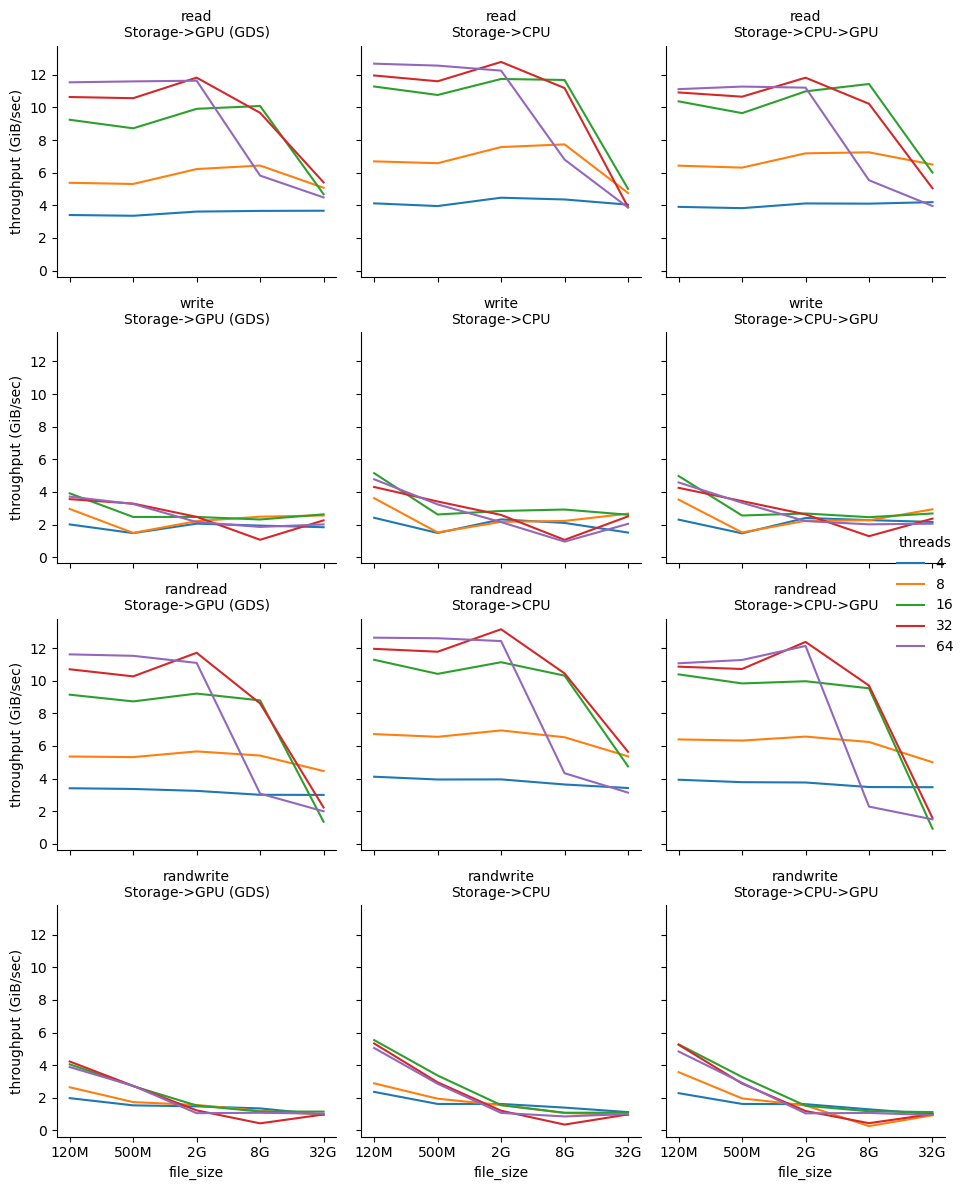

In [17]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="op_type")
g.set_titles("{row_name}\n{col_name}")
g.map_dataframe(
    sns.lineplot, x="file_size", y="throughput (GiB/sec)", hue="threads",
    palette=sns.color_palette(n_colors=measurements_df.threads.nunique())
)
g.add_legend(title="threads")
plt.tight_layout()
plt.savefig(f"img/{DATA_DIR}/throughput-dgx-4-hdd.eps", format="eps")
plt.show()

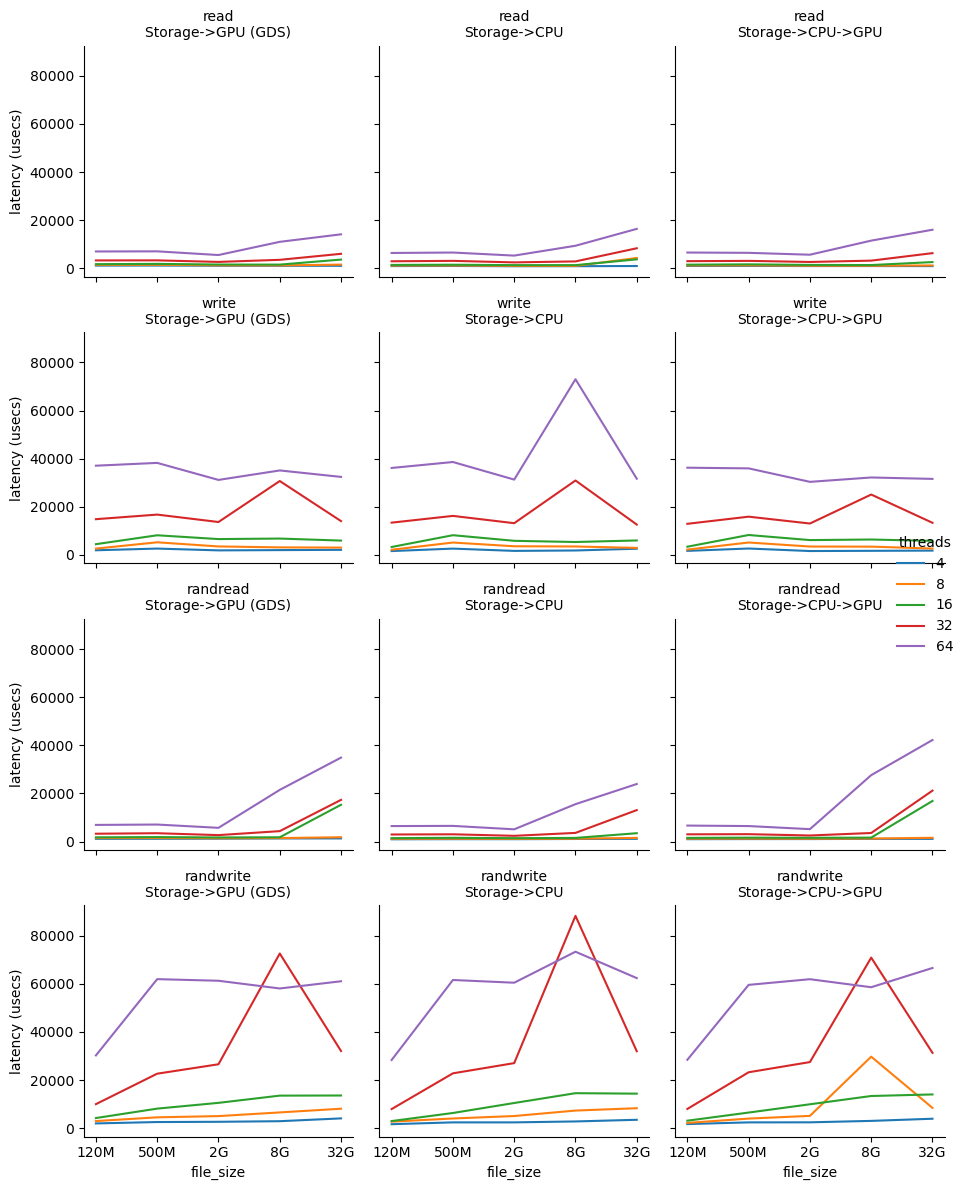

In [18]:
g = sns.FacetGrid(measurements_df, col="xfer_type", row="op_type")
g.set_titles("{row_name}\n{col_name}")
g.map_dataframe(
    sns.lineplot, x="file_size", y="latency (usecs)", hue="threads",
    palette=sns.color_palette(n_colors=measurements_df.threads.nunique())
)
g.add_legend(title="threads")
plt.tight_layout()
plt.savefig(f"img/{DATA_DIR}/latency-dgx-4-hdd.eps", format="eps")
plt.show()

# CPU burden

In [19]:
single_metrics_pattern = r"\s*([^\s]+)"
cpu_usage_pattern = rf"avg-cpu:  %user   %nice %system %iowait  %steal   %idle\n{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}{single_metrics_pattern}"
params_path_pattern = r"benchmark-(\d+)-(\d+)-(\d+)-([^-]+)" # "benchmark-$X-$I-$W-$SIZE-${SLURM_JOB_ID}"

In [20]:
cpu_measurements = []

pathlist = Path(DATA_DIR).glob('benchmark-*')

for path in pathlist:
    with open(path / "iostat.out", "r") as f:
        content = f.read()
        
    cpu_matches = re.findall(cpu_usage_pattern, content)
    params_match = re.search(params_path_pattern, str(path))
    
    if (threads := int(params_match.group(3))) == 128:
        continue
    if int(params_match.group(1)) in xfer_types_to_skip:
        continue
    
    for i, cpu_match in enumerate(cpu_matches[1:-1], start=1):
        cpu_measurements.append({
            "threads": threads,
            "file_size":  params_match.group(4),
            "xfer_type": parse_xfer_type(params_match.group(1)),
            "op_type": parse_operation_type(params_match.group(2)),
            "observation_index": i,
            **dict(zip(["user_cpu", "nice_cpu", "system_cpu", "iowait_cpu", "steal_cpu", "idle_cpu"], cpu_match))
        })

cpu_measurements_df = pd.DataFrame(cpu_measurements)

In [21]:
cpu_measurements_df["xfer_type"] = cpu_measurements_df["xfer_type"].astype(
    CategoricalDtype(categories=XFER_TYPE_MAPPING.values(), ordered=True)
)
cpu_measurements_df["op_type"] = cpu_measurements_df["op_type"].astype(
    CategoricalDtype(categories=OPERATION_TYPE_MAPPING.values(), ordered=True)
)
cpu_measurements_df["file_size"] = cpu_measurements_df["file_size"].astype(
    CategoricalDtype(categories=["120M", "500M", "2G", "8G", "32G"], ordered=True)
)
for col in cpu_measurements_df.columns:
    if col.endswith("cpu"):
        cpu_measurements_df[col] = cpu_measurements_df[col].astype(float)

In [22]:
cpu_measurements_df

,threads,file_size,xfer_type,op_type,observation_index,user_cpu,nice_cpu,system_cpu,iowait_cpu,steal_cpu,idle_cpu
0,64,120M,Storage->GPU (GDS),randwrite,1,0.13,0.0,2.82,0.0,0.0,97.05
1,64,120M,Storage->GPU (GDS),randwrite,2,0.32,0.0,2.42,0.0,0.0,97.26
2,64,120M,Storage->GPU (GDS),randwrite,3,0.03,0.0,2.37,0.0,0.0,97.61
3,64,120M,Storage->GPU (GDS),randwrite,4,0.01,0.0,2.33,0.0,0.0,97.66
4,64,120M,Storage->GPU (GDS),randwrite,5,0.10,0.0,2.45,0.0,0.0,97.45
...,...,...,...,...,...,...,...,...,...,...,...
2547,64,2G,Storage->CPU->GPU,read,5,0.64,0.0,4.91,0.0,0.0,94.45
2548,64,2G,Storage->CPU->GPU,read,6,0.82,0.0,5.53,0.0,0.0,93.65
2549,64,2G,Storage->CPU->GPU,read,7,0.69,0.0,4.70,0.0,0.0,94.62
2550,64,2G,Storage->CPU->GPU,read,8,0.97,0.0,5.71,0.0,0.0,93.32


In [23]:
cpu_measurements_df.groupby(["threads", "file_size", "xfer_type", "op_type"]).count().min()

observation_index    1
user_cpu             1
nice_cpu             1
system_cpu           1
iowait_cpu           1
steal_cpu            1
idle_cpu             1
dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


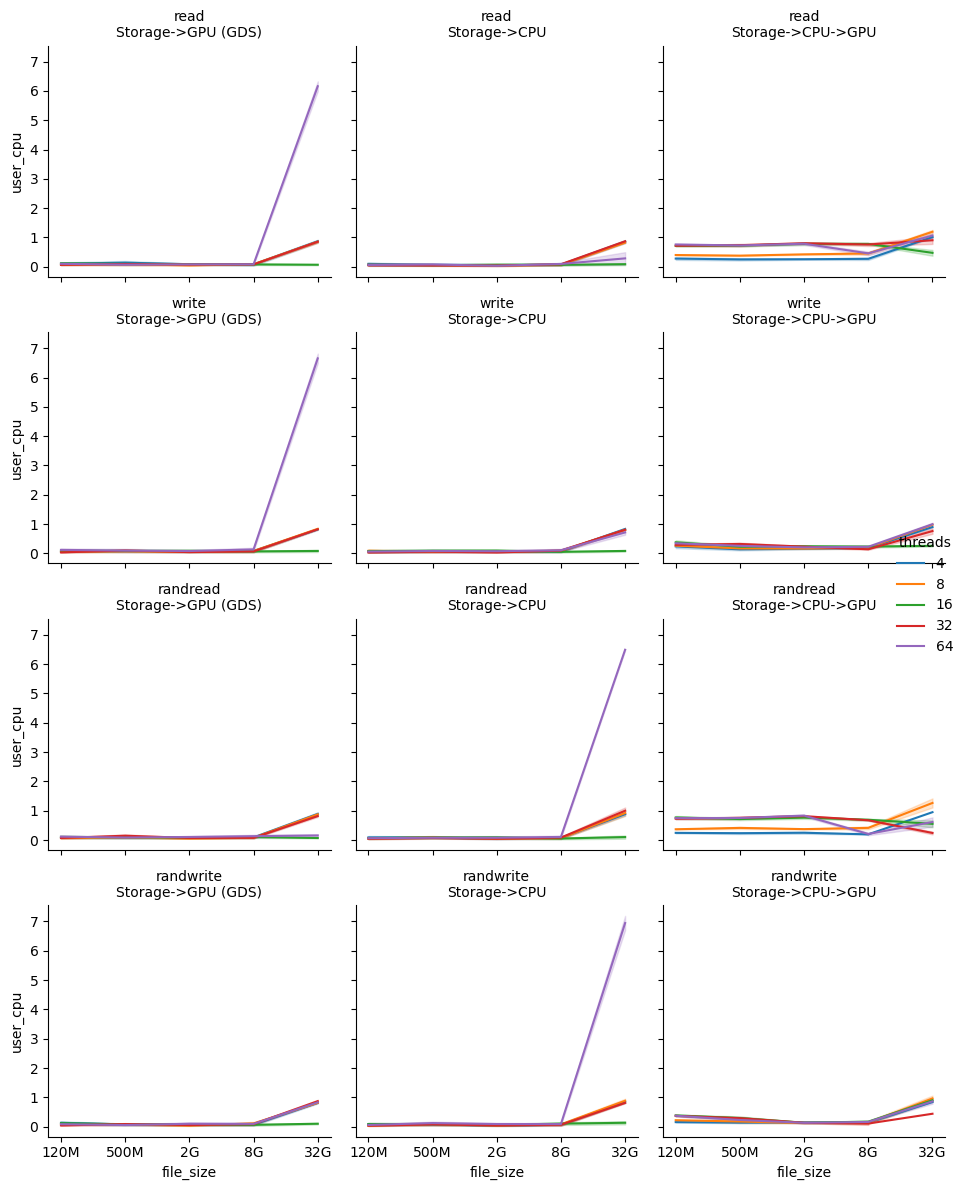

In [24]:
g = sns.FacetGrid(cpu_measurements_df, col="xfer_type", row="op_type")
g.set_titles("{row_name}\n{col_name}")
g.map_dataframe(
    sns.lineplot, x="file_size", y="user_cpu", hue="threads", errorbar="se",
    palette=sns.color_palette(n_colors=measurements_df.threads.nunique())
)
g.add_legend(title="threads")
plt.tight_layout()
plt.savefig(f"img/{DATA_DIR}/cpu-user-dgx-4-hdd.eps", format="eps")
plt.show()